In [ ]:
pip install keras-tuner

     |████████████████████████████████| 133 kB 24.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import pickle
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import glob
import random
import tensorflow as tf
import seaborn as sns
import re
import tarfile
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.optimizers import adam_v2
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
import keras_tuner as kt
from keras import optimizer_v2
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

Mounted at /content/gdrive


In [ ]:
train_annotation = pickle.load(open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/train_annotation.pkl', 'rb'))
test_annotation = pickle.load(open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/test_annotation.pkl', 'rb'))
test_dev_annotation = pickle.load(open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/test_dev_annotation.pkl', 'rb'))

In [ ]:
file = tarfile.open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_train.tar')
file.extractall('/content/vehicle_images')
file.close()

In [ ]:
file = tarfile.open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_test.tar')
file.extractall('/content/vehicle_images')
file.close()

In [ ]:
file = tarfile.open('/content/gdrive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_dev.tar')
file.extractall('/content/vehicle_images')
file.close()

In [ ]:
import os
import shutil

src = '/content/vehicle_images/images_train/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [ ]:
src = '/content/vehicle_images/images_test/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [ ]:
src = '/content/vehicle_images/images_dev/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [ ]:
train_annotation.keys(), test_annotation.keys(), test_dev_annotation.keys()

(dict_keys(['train_im_names', 'wheel_label', 'type_label', 'color_label', 'luggage_label', 'd_part_label', 'sky_label', 'bumper_label']),
 dict_keys(['query_order', 'wheel_label', 'type_label', 'gallery_order', 'color_label', 'luggage_label', 'd_part_label', 'test_im_names', 'bumper_label', 'sky_label']),
 dict_keys(['query_order', 'wheel_label', 'dev_im_names', 'type_label', 'color_label', 'luggage_label', 'd_part_label', 'sky_label', 'bumper_label', 'gallery_order']))

In [ ]:
annotations = {}
for ind in train_annotation['type_label']:
    img_name = train_annotation['train_im_names'][ind]
    annotations[img_name] = train_annotation['type_label'][ind]

In [ ]:
annotations.update(test_annotation['type_label'])
annotations.update(test_dev_annotation['type_label'])

In [ ]:
print(annotations['00000207_0002_00000001.jpg'])

2


In [ ]:
Counter(annotations.values())

Counter({0: 61227, 1: 5551, 2: 42675, 3: 2834, 4: 15398, 5: 9567, 6: 158})

In [ ]:
strategy = {0:1000, 1:1000, 2:1000, 3:1000, 4:1000, 5:1000, 6:0}
undersample = RandomUnderSampler(sampling_strategy = strategy)
X1, y1 = np.array(list(annotations.keys())), np.array(list(annotations.values()))
X1 = X1.reshape(-1,1)
y1 = y1.reshape(-1,1)
annot_name1, annot_label1 = undersample.fit_resample(X1, y1)
Counter(annot_label1)

Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000})

In [ ]:
annot_name1

array([['1TEHK9Z8_C2.jpg'],
       ['4S0IRQ3A_C1.jpg'],
       ['KF95RT8H_C1.jpg'],
       ...,
       ['FF1LX049_C1.jpg'],
       ['SU75LO7B_C1.jpg'],
       ['W69WR1JZ_C2.jpg']], dtype='<U26')

In [ ]:
annot_label1[0]

0

In [ ]:
data1, label1 = [], []
path = '/content/vehicle_images/'
for i in range(6000):
    img_name = path+annot_name1[i][0]
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (352, 352))
    data1.append(img)
    label1.append(annot_label1[i])

label1 = pd.get_dummies(label1).values

In [ ]:
label1

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, label1, test_size=0.2, random_state=42, stratify=label1)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42, stratify=y_train1)

In [ ]:
for i in range(len(X_train1)):
  X_train1[i]=cv2.normalize(X_train1[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
for i in range(len(X_val1)):
  X_val1[i]=cv2.normalize(X_val1[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
for i in range(len(X_test1)):
  X_test1[i]=cv2.normalize(X_test1[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) 

In [ ]:
X_train1 = np.array(X_train1)
X_val1 = np.array(X_val1)
X_test1 = np.array(X_test1)
y_train1 = np.array(y_train1)
y_val1 = np.array(y_val1)
y_test1 = np.array(y_test1)

In [ ]:
d1,d2,d3,d4 = X_train1.shape
X_train1 = X_train1.reshape((d1, d2*d3*d4))
d1,d2,d3,d4 = X_val1.shape
X_val1 = X_val1.reshape((d1, d2*d3*d4))
d1,d2,d3,d4 = X_test1.shape
X_test1 = X_test1.reshape((d1, d2*d3*d4))

In [ ]:
# Simple Neural Network
NN_Simple_model = Sequential()
NN_Simple_model.add(Dense(10, activation="relu", name="layer1"))
NN_Simple_model.add(Dense(9, activation="relu", name="layer2"))
NN_Simple_model.add(Dense(8, activation="relu", name="layer3"))
NN_Simple_model.add(Dense(6, activation="sigmoid", name="out_layer"))
NN_Simple_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'],optimizer=adam_v2.Adam(0.001))

In [ ]:
history = NN_Simple_model.fit(X_train1, y_train1, epochs = 50 , validation_data = (X_val1, y_val1), batch_size=5)

Epoch 1/50
768/768 [==============================] - 46s 60ms/step - loss: 0.4506 - accuracy: 0.1607 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 2/50
768/768 [==============================] - 37s 49ms/step - loss: 0.4506 - accuracy: 0.1589 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 3/50
768/768 [==============================] - 36s 46ms/step - loss: 0.4506 - accuracy: 0.1583 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 4/50
768/768 [==============================] - 33s 43ms/step - loss: 0.4506 - accuracy: 0.1625 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 5/50
768/768 [==============================] - 36s 46ms/step - loss: 0.4506 - accuracy: 0.1565 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 6/50
768/768 [==============================] - 35s 46ms/step - loss: 0.4506 - accuracy: 0.1516 - val_loss: 0.4506 - val_accuracy: 0.1667
Epoch 7/50
768/768 [==============================] - 35s 45ms/step - loss: 0.4506 - accuracy: 0.1583 - val_loss: 0.4506 - val_accuracy:

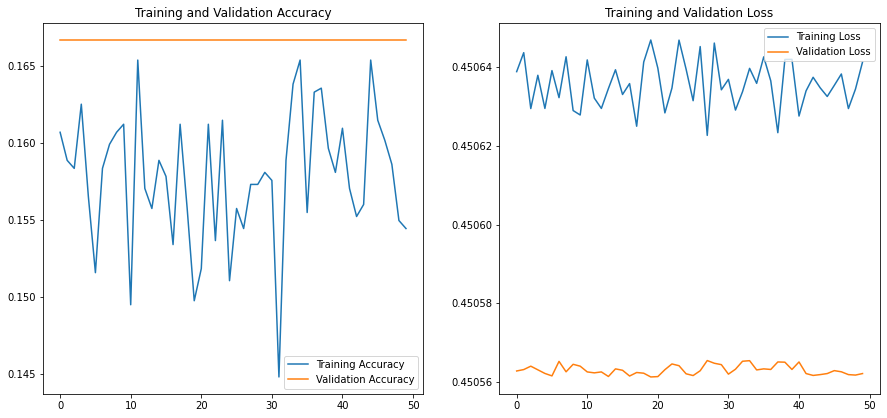

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_pred1 = NN_Simple_model.predict(X_test1)
y_pred1 = np.argmax(y_pred1, axis=1)
test1 = np.argmax(y_test1, axis=1)
print(classification_report(test1, y_pred1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.00      0.00      0.00       200
           2       0.00      0.00      0.00       200
           3       0.00      0.00      0.00       200
           4       0.17      1.00      0.29       200
           5       0.00      0.00      0.00       200

    accuracy                           0.17      1200
   macro avg       0.03      0.17      0.05      1200
weighted avg       0.03      0.17      0.05      1200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred1[128], test1[128]

(4, 4)

In [ ]:
cm = confusion_matrix(test1, y_pred1)
cm_df = pd.DataFrame(cm,
                     index = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'], 
                     columns = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'])

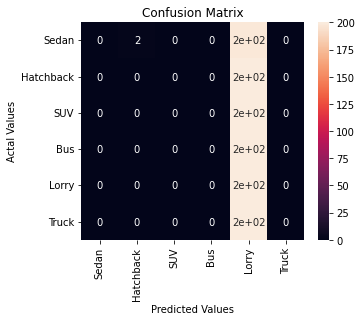

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.compile(
        optimizer=adam_v2.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='VRAI')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X_train1, y_train1,
             epochs=5,
             validation_data=(X_val1, y_val1))

In [ ]:
tuner.results_summary()

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(160, activation="relu", name="layer1"))
nn_model.add(Dense(384, activation="relu", name="layer2"))
nn_model.add(Dense(64, activation="relu", name="layer3"))
nn_model.add(Dense(448, activation="relu", name="layer4"))
nn_model.add(Dense(96, activation="relu", name="layer5"))
nn_model.add(Dense(32, activation="relu", name="layer6"))
nn_model.add(Dense(32, activation="relu", name="layer7"))
nn_model.add(Dense(6, activation="sigmoid", name="out_layer"))
nn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'],optimizer=adam_v2.Adam(0.001))

In [ ]:
history = nn_model.fit(X_train1, y_train1, epochs = 50, validation_data = (X_val1, y_val1), batch_size=32)

Epoch 1/50
120/120 [==============================] - 48s 382ms/step - loss: 3.0134 - accuracy: 0.2320 - val_loss: 1.6285 - val_accuracy: 0.2625
Epoch 2/50
120/120 [==============================] - 45s 375ms/step - loss: 1.6693 - accuracy: 0.2919 - val_loss: 1.5815 - val_accuracy: 0.3052
Epoch 3/50
120/120 [==============================] - 46s 386ms/step - loss: 1.6196 - accuracy: 0.3099 - val_loss: 1.5818 - val_accuracy: 0.3260
Epoch 4/50
120/120 [==============================] - 46s 382ms/step - loss: 1.5405 - accuracy: 0.3589 - val_loss: 1.5455 - val_accuracy: 0.3427
Epoch 5/50
120/120 [==============================] - 45s 374ms/step - loss: 1.4615 - accuracy: 0.3997 - val_loss: 1.6057 - val_accuracy: 0.3177
Epoch 6/50
120/120 [==============================] - 45s 372ms/step - loss: 1.4123 - accuracy: 0.4201 - val_loss: 1.5347 - val_accuracy: 0.3729
Epoch 7/50
120/120 [==============================] - 44s 369ms/step - loss: 1.3689 - accuracy: 0.4344 - val_loss: 1.5789 - val_ac

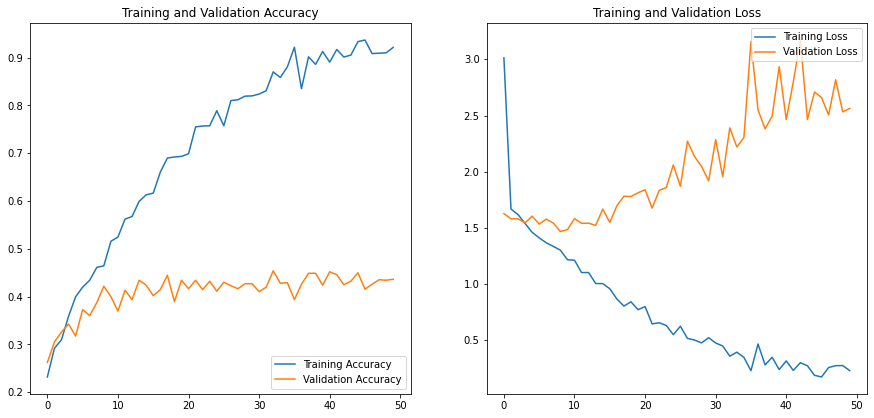

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_pred1 = nn_model.predict(X_test1)
y_pred1 = np.argmax(y_pred1, axis=1)
test1 = np.argmax(y_test1, axis=1)
print(classification_report(test1, y_pred1))

              precision    recall  f1-score   support

           0       0.36      0.28      0.32       200
           1       0.37      0.40      0.38       200
           2       0.33      0.34      0.34       200
           3       0.50      0.67      0.57       200
           4       0.46      0.41      0.43       200
           5       0.47      0.41      0.43       200

    accuracy                           0.42      1200
   macro avg       0.41      0.42      0.41      1200
weighted avg       0.41      0.42      0.41      1200



In [ ]:
cm = confusion_matrix(test1, y_pred1)
cm_df = pd.DataFrame(cm,
                     index = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'], 
                     columns = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'])

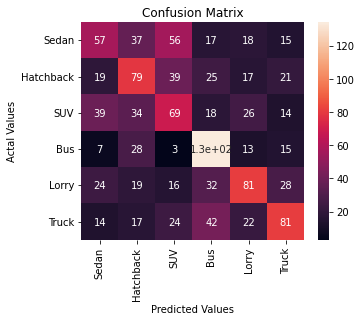

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [ ]:
strategy = {0:1500, 1:950, 2:1500, 3:700, 4:1300, 5:1150, 6:0}
undersample = RandomUnderSampler(sampling_strategy = strategy)
X2, y2 = np.array(list(annotations.keys())), np.array(list(annotations.values()))
X2 = X2.reshape(-1,1)
y2 = y2.reshape(-1,1)
annot_name2, annot_label2 = undersample.fit_resample(X2, y2)
Counter(annot_label2)

Counter({0: 1500, 1: 950, 2: 1500, 3: 700, 4: 1300, 5: 1150})

In [ ]:
annot_name2

array([['VJAYUTIC_C1.jpg'],
       ['LMXXKMVU_C1.jpg'],
       ['DQWNELDJ_C1.jpg'],
       ...,
       ['YV052339_C2.jpg'],
       ['4MB4R764_C2.jpg'],
       ['4ESMQLMH_C1.jpg']], dtype='<U26')

In [ ]:
annot_label2[0]

0

In [ ]:
len(annot_name2), len(annot_label2)

(7100, 7100)

In [ ]:
data2, label2 = [], []
path = '/content/vehicle_images/'
for i in range(7100):
    img_name = path+annot_name2[i][0]
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (352, 352))
    data2.append(img)
    label2.append(annot_label2[i])

label2 = pd.get_dummies(label2).values

In [ ]:
label2

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, label2, test_size=0.2, random_state=42, stratify=label2)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42, stratify=y_train2)

In [ ]:
len(X_train2), len(X_test2), len(X_val2)

(4544, 1420, 1136)

In [ ]:
for i in range(len(X_train2)):
  X_train2[i]=cv2.normalize(X_train2[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
for i in range(len(X_val2)):
  X_val2[i]=cv2.normalize(X_val2[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
for i in range(len(X_test2)):
  X_test2[i]=cv2.normalize(X_test2[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) 

In [ ]:
X_train2 = np.array(X_train2)
X_val2 = np.array(X_val2)
X_test2 = np.array(X_test2)
y_train2 = np.array(y_train2)
y_val2 = np.array(y_val2)
y_test2 = np.array(y_test2)

In [ ]:
d1,d2,d3,d4 = X_train2.shape
X_train2 = X_train2.reshape((d1, d2*d3*d4))
d1,d2,d3,d4 = X_val2.shape
X_val2 = X_val2.reshape((d1, d2*d3*d4))
d1,d2,d3,d4 = X_test2.shape
X_test2 = X_test2.reshape((d1, d2*d3*d4))

In [ ]:
# Simple Neural Network
NN_Simple_model = Sequential()
NN_Simple_model.add(Dense(10, activation="relu", name="layer1"))
NN_Simple_model.add(Dense(9, activation="relu", name="layer2"))
NN_Simple_model.add(Dense(8, activation="relu", name="layer3"))
NN_Simple_model.add(Dense(6, activation="sigmoid", name="out_layer"))
NN_Simple_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'],optimizer=adam_v2.Adam(0.001))

In [ ]:
history = NN_Simple_model.fit(X_train2, y_train2, epochs = 50 , validation_data = (X_val2, y_val2), batch_size=5)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


909/909 [==============================] - 37s 40ms/step - loss: 0.5891 - accuracy: 0.1719 - val_loss: 0.4581 - val_accuracy: 0.1620
Epoch 2/50
909/909 [==============================] - 34s 37ms/step - loss: 0.4473 - accuracy: 0.2003 - val_loss: 0.4445 - val_accuracy: 0.2113
Epoch 3/50
909/909 [==============================] - 33s 37ms/step - loss: 0.4446 - accuracy: 0.2117 - val_loss: 0.4443 - val_accuracy: 0.2113
Epoch 4/50
909/909 [==============================] - 33s 36ms/step - loss: 0.4445 - accuracy: 0.2132 - val_loss: 0.4445 - val_accuracy: 0.2113
Epoch 5/50
909/909 [==============================] - 32s 36ms/step - loss: 0.4445 - accuracy: 0.2095 - val_loss: 0.4444 - val_accuracy: 0.2113
Epoch 6/50
909/909 [==============================] - 33s 36ms/step - loss: 0.4446 - accuracy: 0.2159 - val_loss: 0.4444 - val_accuracy: 0.2113
Epoch 7/50
909/909 [==============================] - 37s 40ms/step - loss: 0.4446 - accuracy: 0.2073 - val_loss: 0.4445 - val_accuracy: 0.2113
Epo

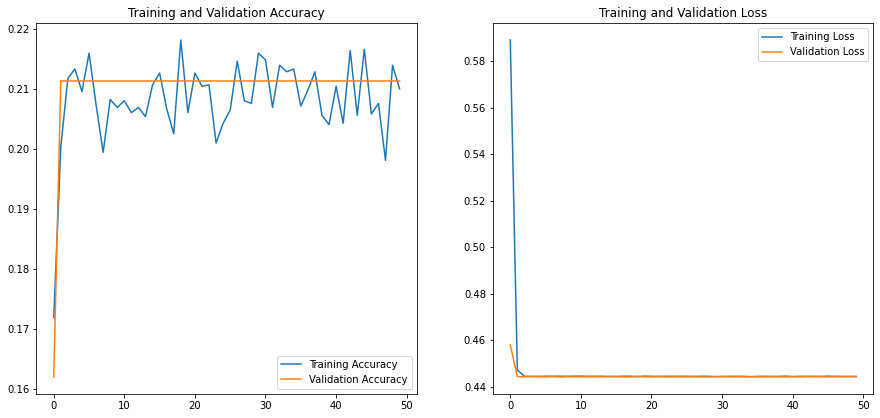

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_pred2 = NN_Simple_model.predict(X_test2)
y_pred2 = np.argmax(y_pred2, axis=1)
test2 = np.argmax(y_test2, axis=1)
print(classification_report(test2, y_pred2))

              precision    recall  f1-score   support

           0       0.21      1.00      0.35       300
           1       0.00      0.00      0.00       190
           2       0.00      0.00      0.00       300
           3       0.00      0.00      0.00       140
           4       0.00      0.00      0.00       260
           5       0.00      0.00      0.00       230

    accuracy                           0.21      1420
   macro avg       0.04      0.17      0.06      1420
weighted avg       0.04      0.21      0.07      1420



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred2[128], test2[128]

In [ ]:
cm = confusion_matrix(test2, y_pred2)
cm_df = pd.DataFrame(cm,
                     index = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'], 
                     columns = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'])

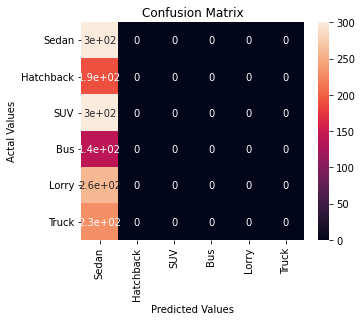

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
def build_model2(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.compile(
        optimizer=adam_v2.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'])
    return model

In [ ]:
tuner1 = kt.RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='VRAI')

In [ ]:
tuner1.search_space_summary()

In [ ]:
tuner1.search(X_train2, y_train2,
             epochs=5,
             validation_data=(X_val2, y_val2))

In [ ]:
tuner1.results_summary()

units_0: 416
units_1: 160
learning_rate: 0.0001
units_2: 64
units_3: 384
units_4: 160
units_5: 384
units_6: 320
units_7: 288
units_8: 256
units_9: 288
units_10: 96
units_11: 352
units_12: 320
units_13: 160
units_14: 192
units_15: 256
units_16: 64
units_17: 96
units_18: 256
units_19: 128

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(416, activation="relu", name="layer1"))
nn_model.add(Dense(160, activation="relu", name="layer2"))
nn_model.add(Dense(64, activation="relu", name="layer3"))
nn_model.add(Dense(384, activation="relu", name="layer4"))
nn_model.add(Dense(160, activation="relu", name="layer5"))
nn_model.add(Dense(384, activation="relu", name="layer6"))
nn_model.add(Dense(320, activation="relu", name="layer7"))
nn_model.add(Dense(288, activation="relu", name="layer8"))
nn_model.add(Dense(256, activation="relu", name="layer9"))
nn_model.add(Dense(288, activation="relu", name="layer10"))
nn_model.add(Dense(96, activation="relu", name="layer11"))
nn_model.add(Dense(352, activation="relu", name="layer12"))
nn_model.add(Dense(320, activation="relu", name="layer13"))
nn_model.add(Dense(160, activation="relu", name="layer14"))
nn_model.add(Dense(192, activation="relu", name="layer15"))
nn_model.add(Dense(256, activation="relu", name="layer16"))
nn_model.add(Dense(64, activation="relu", name="layer17"))
nn_model.add(Dense(96, activation="relu", name="layer18"))
nn_model.add(Dense(256, activation="relu", name="layer19"))
nn_model.add(Dense(128, activation="relu", name="layer20"))
nn_model.add(Dense(6, activation="sigmoid", name="out_layer"))
nn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'],optimizer=adam_v2.Adam(0.001))

In [ ]:
history = nn_model.fit(X_train2, y_train2, epochs = 50, validation_data = (X_val2, y_val2), batch_size=32)

Epoch 1/50
142/142 [==============================] - 137s 931ms/step - loss: 1.7719 - accuracy: 0.2154 - val_loss: 1.7530 - val_accuracy: 0.2113
Epoch 2/50
142/142 [==============================] - 126s 889ms/step - loss: 1.7397 - accuracy: 0.2287 - val_loss: 1.7565 - val_accuracy: 0.2113
Epoch 3/50
142/142 [==============================] - 127s 897ms/step - loss: 1.7470 - accuracy: 0.2179 - val_loss: 1.7550 - val_accuracy: 0.2113
Epoch 4/50
142/142 [==============================] - 127s 895ms/step - loss: 1.7503 - accuracy: 0.2128 - val_loss: 1.7098 - val_accuracy: 0.2553
Epoch 5/50
142/142 [==============================] - 135s 950ms/step - loss: 1.7229 - accuracy: 0.2379 - val_loss: 1.7224 - val_accuracy: 0.2623
Epoch 6/50
142/142 [==============================] - 134s 948ms/step - loss: 1.6569 - accuracy: 0.2755 - val_loss: 1.6493 - val_accuracy: 0.2738
Epoch 7/50
142/142 [==============================] - 130s 917ms/step - loss: 1.6179 - accuracy: 0.2898 - val_loss: 1.6122 -

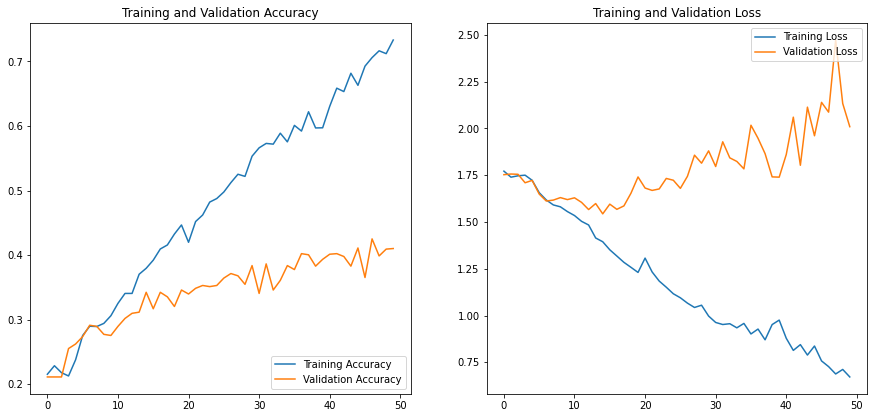

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_pred2 = nn_model.predict(X_test2)
y_pred2 = np.argmax(y_pred2, axis=1)
test2 = np.argmax(y_test2, axis=1)
print(classification_report(test2, y_pred2))

              precision    recall  f1-score   support

           0       0.33      0.64      0.44       300
           1       0.00      0.00      0.00       190
           2       0.43      0.30      0.35       300
           3       0.85      0.41      0.55       140
           4       0.36      0.53      0.43       260
           5       0.43      0.34      0.38       230

    accuracy                           0.39      1420
   macro avg       0.40      0.37      0.36      1420
weighted avg       0.38      0.39      0.36      1420



In [ ]:
cm = confusion_matrix(test2, y_pred2)
cm_df = pd.DataFrame(cm,
                     index = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'], 
                     columns = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'])

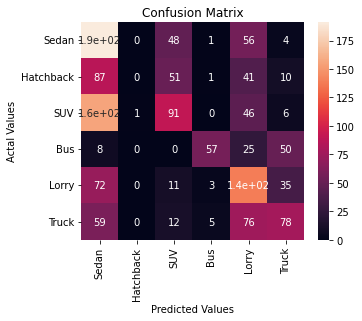

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////